# Detection of Tip-Jets in CMIP6

The goal of this notebook is to present the methodology to detect Tip-Jets in CMIP6 simulations. In the first part of the notebook, we load and pre-process the data accessible directly on Google Servers. Second, we implement the detection methodology to detect Tip-Jets following the methodology developed by Vage et al. (2009) based on EOF decomposition of wind speed, temperature and sea level pressure.

**Ref:**
Våge, K., Spengler, T., Davies, H.C. and Pickart, R.S. (2009), Multi-event analysis of the westerly Greenland tip jet based upon 45 winters in ERA-40. Q.J.R. Meteorol. Soc., 135: 1999-2011. https://doi.org/10.1002/qj.488

https://rpickart.whoi.edu/wp-content/uploads/sites/53/2016/09/Vage-et-all-2009-muti-event-analysis.pdf

In [1]:
# Install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=ce03b3abf6a326de531444cbfa8a6cf37fb4f3fa9248c8f50ba3d64d6a18b9bf
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=Shapely-1.8.5-cp310-cp310-linux_x86_64.whl size=832073 sha256=c616bf488919c2816869437c7b89afaaccb

In [2]:
# Import the classical libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
# gcsfs to read data from online storage
import gcsfs
# sklearn for the EOF decomposition
from sklearn.decomposition import PCA
# mit to find consecutive numbers in a given list
import more_itertools as mit
# cartopy to plot geographical maps
import cartopy.crs as ccrs
# pyproj to compute clean distance between longitudes and latitudes
from pyproj import Geod
g = Geod(ellps='WGS84')

## Load and pre-process the historical data from ACCESS-ESM1-5

In [80]:
# load the dataset
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# find the zonal (x-direction) wind data to start
# activity_id is the type of CMIP experiment, the historical run are in the classical "CMIP" while the future scenarios are in "ScenarioMIP"
# table_id is generally the frequency of data spanning (hourly, daily, yearly...)
# experiment_id is genrally the type of forcing used for the runs, here "historical" is based on past observations
# variable_id is the quantity we want, "uas" means U-velocity (zonal) Atmopshere Surface
# the source is the model we want since many models reproduce the same experiments
# finally, we can select the member we want

df_uas = df.query("activity_id=='CMIP' & table_id=='day' & variable_id=='uas' & experiment_id=='historical' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")
# df_uas = df.query("activity_id=='CMIP' & table_id=='day' & variable_id=='uas' & experiment_id=='historical' & source_id=='IPSL-CM6A-LR' & member_id=='r2i1p1f1'")

# setup the gcs access
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store
zstore = df_uas.zstore.values[-1]

# create a mapping interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds_uas = xr.open_zarr(mapper, consolidated=True,decode_times=False).uas

In [4]:
# Select data in the region for a quick look

lon_min, lon_max, lat_min, lat_max = 360-60, 360-25, 55, 65

mask = (ds_uas.lat>lat_min)&(ds_uas.lat<lat_max)&(ds_uas.lon>lon_min)&(ds_uas.lon<lon_max)

ds_area = ds_uas.where(mask, drop=True)

In [5]:
# # D,s,ms,us,ns
# ds_uas['time'] = pd.to_datetime(ds_uas['time'], unit='D', origin=pd.Timestamp('1950-01-01'))
# ds_uas.resample(time='D').mean()

Text(0.5, 1.0, 'Azonal wind on the area of interest (01/01/1950)')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


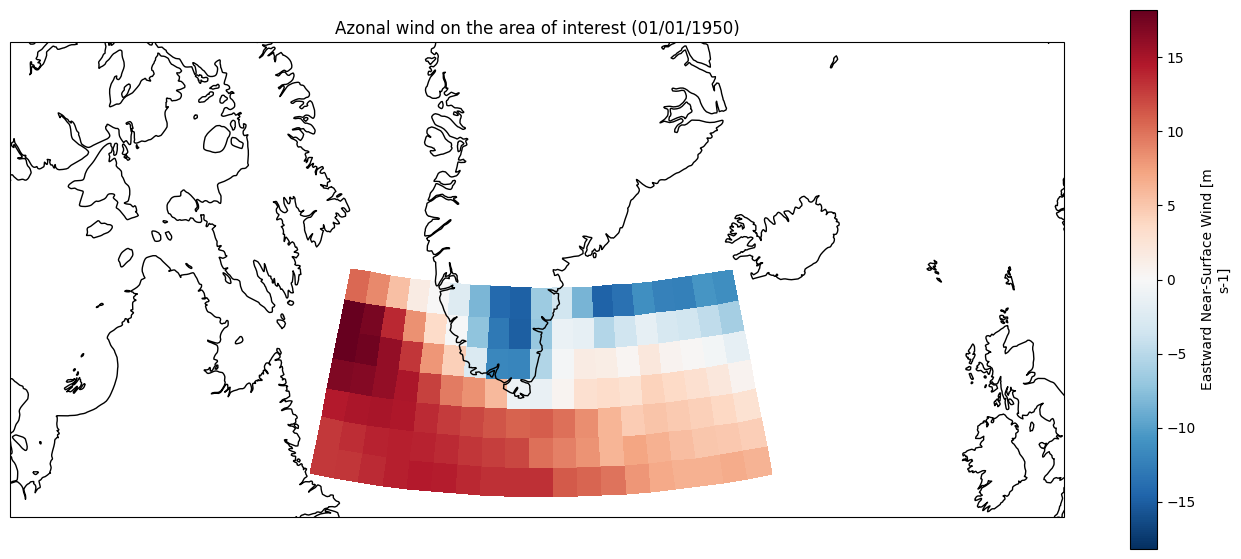

In [5]:
# Plot

plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_area.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title('Azonal wind on the area of interest (01/01/1950)')

#### Data needed for Tip-Jet detection

The map below present the required data. In the grey area, we will have to compute the point where the wind speed (both zonal and meridional components) **(variable_id=='sfcWind')** is maximum. At this location of maximum speed we will extract the surface temperature of the atmosphere **(variable_id=='tas')** and the zonal wind velocity **(variable_id=='uas')**.
Then, we want to compute the sea level pressure **(variable_id=='slp')** gradients along the three colored lines, for that we can just take the difference between the ends of each lines.

In [6]:
lon_a, lat_a = 360+np.linspace(-47, -40, 20), np.linspace(60, 62, 20)
lon_b, lat_b = 360+np.linspace(-45, -40, 20), np.linspace(57, 62, 20)
lon_c, lat_c = 360+np.linspace(-40, -40, 20), np.linspace(56.5, 62, 20)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


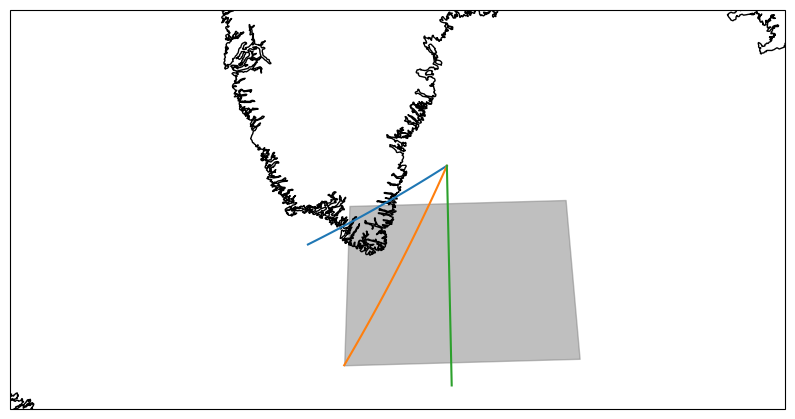

In [7]:
fig = plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))

# Area of interest
ax.fill_between([-45, -34], 57, 61, color='grey', alpha=0.5, transform=ccrs.PlateCarree())

# Gradient pressure lines
ax.plot(lon_a, lat_a, transform=ccrs.PlateCarree())
ax.plot(lon_b, lat_b, transform=ccrs.PlateCarree())
ax.plot(lon_c, lat_c, transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_extent([-60, -25, 55, 65])

### Extract uas from the grey area

In [8]:
wind_area_u = ds_uas.where((ds_uas.lat>57)&(ds_uas.lat<61)&(ds_uas.lon>360-45)&(ds_uas.lon<360-34), drop=True)

### Load wind magnitude data

In [9]:
df_mag = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='sfcWind' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")
# df_mag = df.query("activity_id=='CMIP' & table_id=='day' & variable_id=='sfcWind' & experiment_id=='historical' & source_id=='IPSL-CM6A-LR' & member_id=='r2i1p1f1'")

zstore = df_mag.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_windmag = xr.open_zarr(mapper, consolidated=True,decode_times=False).sfcWind

In [10]:
ds_windmag.lon.values, ds_uas.lon.values

(array([  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,  11.25 ,
         13.125,  15.   ,  16.875,  18.75 ,  20.625,  22.5  ,  24.375,
         26.25 ,  28.125,  30.   ,  31.875,  33.75 ,  35.625,  37.5  ,
         39.375,  41.25 ,  43.125,  45.   ,  46.875,  48.75 ,  50.625,
         52.5  ,  54.375,  56.25 ,  58.125,  60.   ,  61.875,  63.75 ,
         65.625,  67.5  ,  69.375,  71.25 ,  73.125,  75.   ,  76.875,
         78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,  90.   ,
         91.875,  93.75 ,  95.625,  97.5  ,  99.375, 101.25 , 103.125,
        105.   , 106.875, 108.75 , 110.625, 112.5  , 114.375, 116.25 ,
        118.125, 120.   , 121.875, 123.75 , 125.625, 127.5  , 129.375,
        131.25 , 133.125, 135.   , 136.875, 138.75 , 140.625, 142.5  ,
        144.375, 146.25 , 148.125, 150.   , 151.875, 153.75 , 155.625,
        157.5  , 159.375, 161.25 , 163.125, 165.   , 166.875, 168.75 ,
        170.625, 172.5  , 174.375, 176.25 , 178.125, 180.   , 181.875,
      

### U-wind and wind magnitude grid are not the same

As we can see in the above cell, the longitude axis for the u-wind and for the wind magnitude are different. This is due to the grid use in some models.

As you can see on the figure below, some models put their outputs in the C-grid they used for the computation instead of interpolating then into a A-grid. While in A-grid all data are located at the same locations, in a C-grid the zonal and meridional vectors are located at cell edges and the scalar data are located at the center of the cells.

To solve this issue, we can simply take a slighlty greater grid for the wing magnitude and re-interpolate linearly the data at the cell edges along the x-axis. As you can see on the schematic, the data are already colocated along the y-axis.

<img src="https://www.researchgate.net/publication/335242683/figure/fig2/AS:793660530630660@1566234824795/Arakawas-staggered-grids-Arakawa-and-Lamb-1977-a-A-grid-and-b-C-grid-In-the-C.ppm" style="height: 100px; width:100px;"/>

**Ref:** The Parcels v2.0 Lagrangian framework: new field interpolation schemes - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Arakawas-staggered-grids-Arakawa-and-Lamb-1977-a-A-grid-and-b-C-grid-In-the-C_fig2_335242683

In [11]:
# We select the area and the data since 1950
wind_mag_area= ds_windmag.where((ds_windmag.lat>57)&(ds_windmag.lat<61)&(ds_windmag.lon>360-46)&(ds_windmag.lon<360-33), drop=True).isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size))

# we convert the xr.Dataarray to np.array
magnitude_np = wind_mag_area.values

# Linear interpolation along x
magnitude_at_u = 0.5*(magnitude_np[:,:,:-1]+magnitude_np[:,:,1:])

In [12]:
# We can check that the interpolation brings us the right location

print((wind_mag_area.lon.values[:-1]+wind_mag_area.lon.values[1:])/2)

print(wind_area_u.lon.values)

[315.9375 317.8125 319.6875 321.5625 323.4375 325.3125]
[315.9375 317.8125 319.6875 321.5625 323.4375 325.3125]


In [13]:
# Now to find the location of the maximum, we can ravel the 2D data into 1D at each time-steps to make easier finding the maximum, and use argmax to find its location at each time step.

wind_mag_area_ravelled = np.array([magnitude_at_u[i].ravel() for i in range(len(magnitude_at_u))]) # This for loop look at the maximum for each time step

argmax_wind = np.argmax(wind_mag_area_ravelled, axis=1)

# We do the same to extract uas at this maximum
u_np = wind_area_u.values
u_at_max = np.array([u_np[i].ravel()[argmax_wind[i]] for i in range(len(u_np))])

In [15]:
# # We select the area and the data since 1950
# wind_mag_area= ds_windmag.where((ds_windmag.lat>57)&(ds_windmag.lat<61)&(ds_windmag.lon>360-45)&(ds_windmag.lon<360-34), drop=True).isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size))

# #wind_mag_area= ds_windmag.where((ds_windmag.time>=36524) & (ds_windmag.lat>57)&(ds_windmag.lat<61)&(ds_windmag.lon>360-45)&(ds_windmag.lon<360-34), drop=True).isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size))
# magnitude_np = wind_mag_area.values
# magnitude_at_u = magnitude_np

In [16]:
# # Now to find the location of the maximum, we can ravel the 2D data into 1D at each time-steps to make easier finding the maximum, and use argmax to find its location at each time step.

# wind_mag_area_ravelled = np.array([magnitude_at_u[i].ravel() for i in range(len(magnitude_at_u))]) # This for loop look at the maximum for each time step

# argmax_wind = np.argmax(wind_mag_area_ravelled, axis=1)

# # We do the same to extract uas at this maximum
# u_np = wind_area_u.values
# u_at_max = np.array([u_np[i].ravel()[argmax_wind[i]] for i in range(len(u_np))])

### Load and process temperature data

Now, we can do the same with temperature data (tas). It will be easier since it is already located at the cell center.

In [14]:
# Load data

df_tas = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='tas' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")
# df_tas = df.query("activity_id=='CMIP' & table_id=='day' & variable_id=='tas' & experiment_id=='historical' & source_id=='IPSL-CM6A-LR' & member_id=='r2i1p1f1'")

zstore = df_tas.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_temp = xr.open_zarr(mapper, consolidated=True,decode_times=False).tas

In [15]:
# Extract the grey area and the data after 1950

temp_area = ds_temp.where((ds_temp.lat>57)&(ds_temp.lat<61)&(ds_temp.lon>360-46)&(ds_temp.lon<360-33), drop=True).isel(time=np.arange(ds_temp.time.size-ds_uas.time.size, ds_temp.time.size))


In [16]:
# Find the location of the maximum for each time step

wind_mag_area_ravelled = np.array([magnitude_np[i].ravel() for i in range(len(magnitude_np))])

argmax_wind = np.argmax(wind_mag_area_ravelled, axis=1)

# Extract the temperature at these maximums

t_np = temp_area.values

t_at_max = np.array([t_np[i].ravel()[argmax_wind[i]] for i in range(len(t_np))])-273.15 # Here we can remove -273.15 to convert the data into celsius degree

### Load Sea Level Pressure (SLP) data

In [17]:
df_psl = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id=='historical' & variable_id=='psl' & source_id=='ACCESS-ESM1-5' & member_id=='r1i1p1f1'")
# df_psl = df.query("activity_id=='CMIP' & table_id=='day' & variable_id=='psl' & experiment_id=='historical' & source_id=='IPSL-CM6A-LR' & member_id=='r2i1p1f1'")

In [18]:
zstore = df_psl.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_slp = xr.open_zarr(mapper, consolidated=True,decode_times=False).psl

# select data after 1950
ds_slp = ds_slp.isel(time=np.arange(ds_slp.time.size-ds_uas.time.size, ds_slp.time.size))

Find the nearest node in the model data

In [19]:
nearest_a_start = ds_slp.sel(lon=lon_a[0], lat=lat_a[0], method='nearest')
nearest_a_end = ds_slp.sel(lon=lon_a[-1], lat=lat_a[-1], method='nearest')
nearest_b_start = ds_slp.sel(lon=lon_b[0], lat=lat_b[0], method='nearest')
nearest_b_end = ds_slp.sel(lon=lon_b[-1], lat=lat_b[-1], method='nearest')
nearest_c_start = ds_slp.sel(lon=lon_c[0], lat=lat_c[0], method='nearest')
nearest_c_end = ds_slp.sel(lon=lon_c[-1], lat=lat_c[-1], method='nearest')

Check that the nearest node is not too far or in a wrong place (like on Greenland)

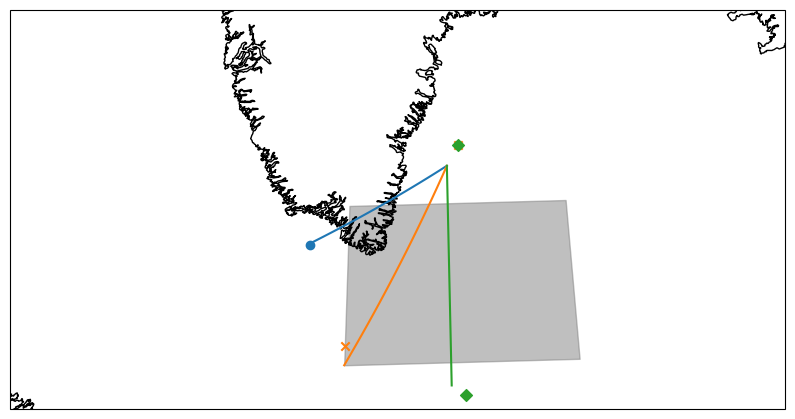

In [20]:
fig = plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))

ax.fill_between([-45, -34], 57, 61, color='grey', alpha=0.5, transform=ccrs.PlateCarree())

ax.plot(lon_a, lat_a, transform=ccrs.PlateCarree())
ax.plot(lon_b, lat_b, transform=ccrs.PlateCarree())
ax.plot(lon_c, lat_c, transform=ccrs.PlateCarree())

plt.scatter(nearest_a_start.lon.values, nearest_a_start.lat.values, transform=ccrs.PlateCarree(), c='tab:blue')
plt.scatter(nearest_a_end.lon.values, nearest_a_end.lat.values, transform=ccrs.PlateCarree(), c='tab:blue')
plt.scatter(nearest_b_start.lon.values, nearest_b_start.lat.values, transform=ccrs.PlateCarree(), c='tab:orange', marker='x')
plt.scatter(nearest_b_end.lon.values, nearest_b_end.lat.values, transform=ccrs.PlateCarree(), c='tab:orange', marker='x')
plt.scatter(nearest_c_start.lon.values, nearest_c_start.lat.values, transform=ccrs.PlateCarree(), c='tab:green', marker='D')
plt.scatter(nearest_c_end.lon.values, nearest_c_end.lat.values, transform=ccrs.PlateCarree(), c='tab:green', marker='D')
ax.coastlines()
ax.set_extent([-60, -25, 55, 65])

Compute the gradient using g.inv to find the distance between nodes

In [21]:
grad_a = (nearest_a_start - nearest_a_end) / g.inv(nearest_a_start.lon.values, nearest_a_start.lat.values, nearest_a_end.lon.values, nearest_a_end.lat.values)[2]/1000
grad_b = (nearest_b_start - nearest_b_end) / g.inv(nearest_b_start.lon.values, nearest_b_start.lat.values, nearest_b_end.lon.values, nearest_b_end.lat.values)[2]/1000
grad_c = (nearest_c_start - nearest_c_end) / g.inv(nearest_c_start.lon.values, nearest_c_start.lat.values, nearest_c_end.lon.values, nearest_c_end.lat.values)[2]/1000

## Detection of Tip-Jets with EOF from Vage et al. (2009)

### EOF computation

In [22]:
# We build our data matrix on which we will compute the EOF. Their is 2 dimensions: samples (here the time) and the features (here u_at_max, t_at_max and the three slp gradient).
# We therefore want a matrix NxM with N the number of time steps and M=5
from sklearn.preprocessing import StandardScaler

N, M = len(wind_area_u.time.values), 5
X = np.zeros((N, M))

X[:, 0] = u_at_max
X[:, 1] = t_at_max
X[:, 2] = grad_a
X[:, 3] = grad_b
X[:, 4] = grad_c

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
# Use sklearn to compute PCA decompositions, here we only take the first component which is supposed to represent tip-jets

pca = PCA(n_components=1)
pca.fit(X)

Xpca = pca.transform(X)

In [24]:
pca.explained_variance_ratio_

array([0.72174191])

We observe that the temperature is almost not taking into account (the PCA coefficient linked to the temperature is less than 5%). We will delve furthermore on this fact afterwards

In [25]:
pca.components_

array([[ 0.4916985 , -0.04055736,  0.49429893,  0.51821746,  0.4936668 ]])

In [26]:
comp = 0
eof =  Xpca[:, comp]

In [27]:
# Now we create a function to put together the tip-jet detected that are in the same event (with consecutive indices)

def consecutiveGroupes(indices):
    consec = []
    for group in mit.consecutive_groups(indices):
        consec.append(list(group))

    return np.array(consec, dtype='object')

In [28]:
# We can define TJ as the 5% strongest winds, since the treshold proposed by Vage et al. is arbitrary and depend on the resolution of the dataset

print(np.percentile(eof, 95))

events = consecutiveGroupes(np.where(eof>np.percentile(eof, 95))[0])
len(events)

3.115345003359856


798

Now we want to check the consistency of the detected pattern. We will first look at the spatial pattern to see how it looks like. Second, we will look at the frequency to see wether it matches the 586 events between 1957 and 2002 found by Vage et al.

In [29]:
# the frequency match pretty well

len(events)/(2015-1950), 586/(2002-1957)

(12.276923076923078, 13.022222222222222)

The pattern is pretty close to the one described in the paper

In [30]:
ds_windmag_compositeTJ = ds_windmag.isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size)).isel(time=np.where(eof>np.percentile(eof, 95))[0]).mean('time')

We will now have a look at the mean wind magnitude map for a tip-jet event. We see that it corresponds well to a tip-jet

Text(0.5, 1.0, 'Average sea surface wind during Tip-Jet on historical data (1950-2015)')

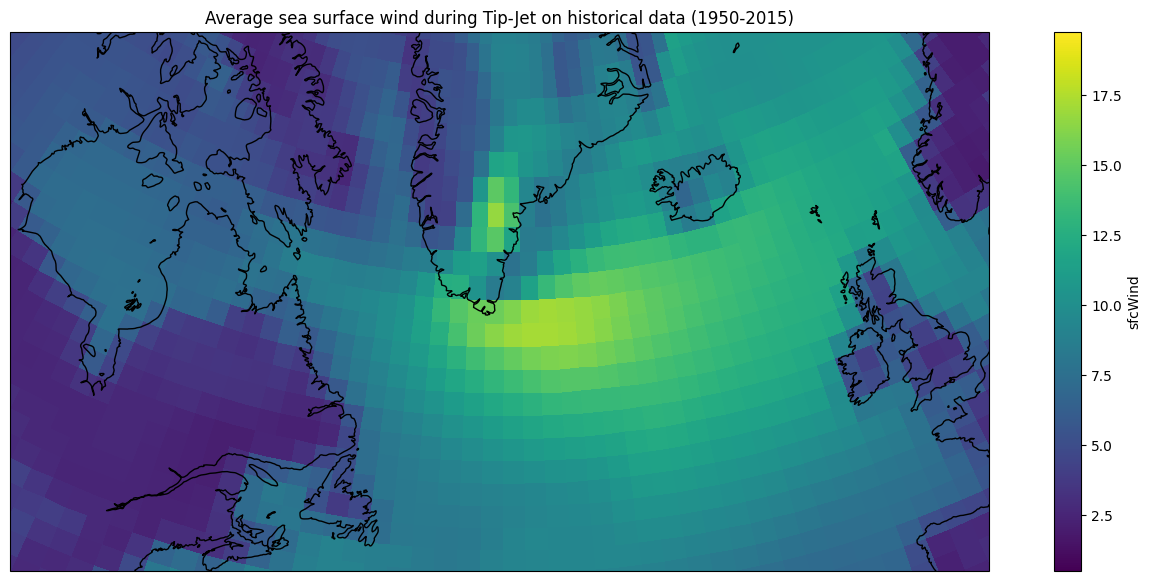

In [31]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 40, 70])
ax.set_title('Average sea surface wind during Tip-Jet on historical data (1950-2015)')

We can now look at the evolution of frequency over time

In [32]:
time_axis = np.arange(np.datetime64('1950-01-01 12:00'), np.datetime64('2015-01-01 12:00'), np.timedelta64(1, 'D'))

time_tip_jet_events = np.array([time_axis[int(np.mean(events[i]))] for i in range(len(events))])

time_axis_yearly = np.arange(np.datetime64('1950'), np.datetime64('2015'), np.timedelta64(1, 'Y'))

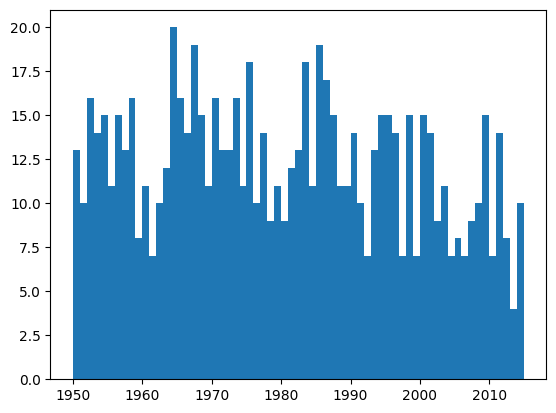

In [33]:
histo_tip_jet = plt.hist(time_tip_jet_events, bins=65)

# We now try to remove some features in order to compare the map obtained and see if some of them are meaningless

## Keep only wind and temperature

In [34]:
# We build our data matrix on which we will compute the EOF. Their is 2 dimensions: samples (here the time) and the features (here u_at_max, t_at_max and the three slp gradient).
# We therefore want a matrix NxM with N the number of time steps and M=5
from sklearn.preprocessing import StandardScaler

N2, M2 = len(wind_area_u.time.values), 2
X2 = np.zeros((N2, M2))

X2[:, 0] = u_at_max
X2[:, 1] = t_at_max
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)

In [35]:
pca2 = PCA(n_components=1)
pca2.fit(X2)

Xpca2 = pca2.transform(X2)

In [36]:
comp2 = 0

eof2 =  Xpca2[:, comp2]

In [37]:
print(np.percentile(eof2, 95))

events2 = consecutiveGroupes(np.where(eof2>np.percentile(eof2, 95))[0])
len(events2)

1.7899208839776122


821

We roughly detect the same amount of Tip-Jets

In [38]:
len(events2)/(2015-1950), 586/(2002-1957)

(12.63076923076923, 13.022222222222222)

In [39]:
ds_windmag_compositeTJ2 = ds_windmag.isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size)).isel(time=np.where(eof2>np.percentile(eof2, 95))[0]).mean('time')

As we can see from the plot bellow, it doesn't correspond to a tip-jet. We don't have on the map an intense azonal wind starting from the Cape Farewell to the east.

Text(0.5, 1.0, 'Mean wind speed detected during Tip-Jet events if we remove pressure information')

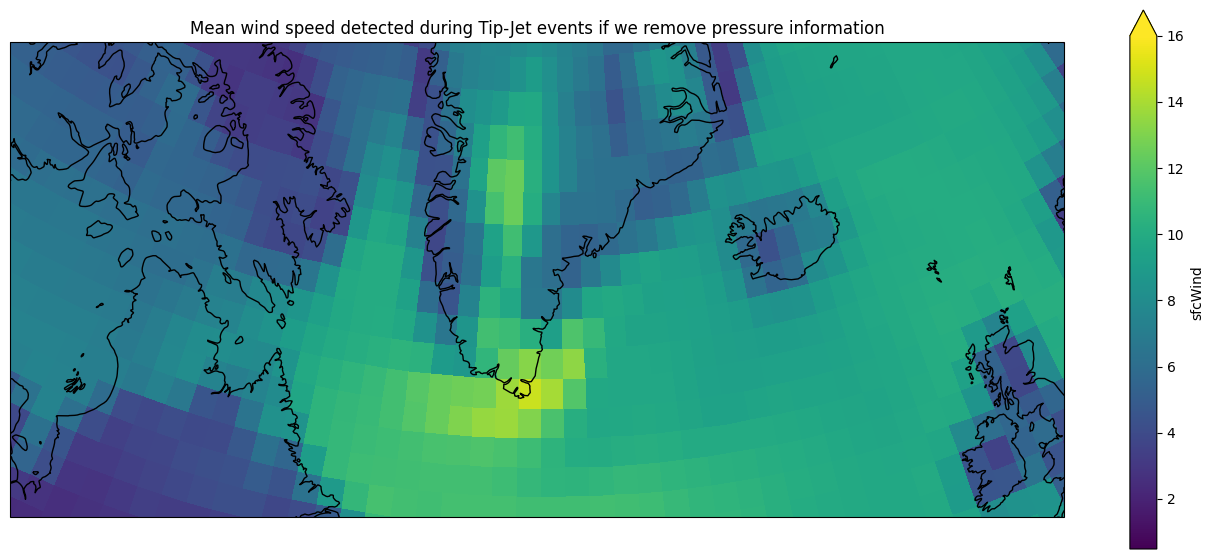

In [40]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ2.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=16)
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed detected during Tip-Jet events if we remove pressure information")

## We'll now try to keep only the wind and gradient pressure data

In [41]:
N3, M3 = len(wind_area_u.time.values), 4
X3 = np.zeros((N3, M3))

X3[:, 0] = u_at_max
X3[:, 1] = grad_a
X3[:, 2] = grad_b
X3[:, 3] = grad_c

scaler3 = StandardScaler()
X3 = scaler3.fit_transform(X3)

In [42]:
# Use sklearn to compute PCA decompositions, here we only take the first component which is supposed to represent tip-jets

pca3 = PCA(n_components=1)
pca3.fit(X3)

Xpca3 = pca3.transform(X3)

In [43]:
comp3 = 0

eof3 =  Xpca3[:, comp3]

In [44]:
print(np.percentile(eof3, 95))

events3 = consecutiveGroupes(np.where(eof3>np.percentile(eof3, 95))[0])
len(events3)

3.094632496952781


804

We still detect a descent amount of Tip-Jets

In [45]:
len(events3)/(2015-1950), 586/(2002-1957)

(12.36923076923077, 13.022222222222222)

In [46]:
ds_windmag_compositeTJ3 = ds_windmag.isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size)).isel(time=np.where(eof3>np.percentile(eof3, 95))[0]).mean('time')

We can see from the map bellow that temparature almost doesn't change anything on the Tip-Jet detection. To be sure of that, we can plot the difference beetwen the map where we put all features and the one where we remove temperature.

Text(0.5, 1.0, 'Mean wind speed detected during Tip-Jet events if we remove temperature information')

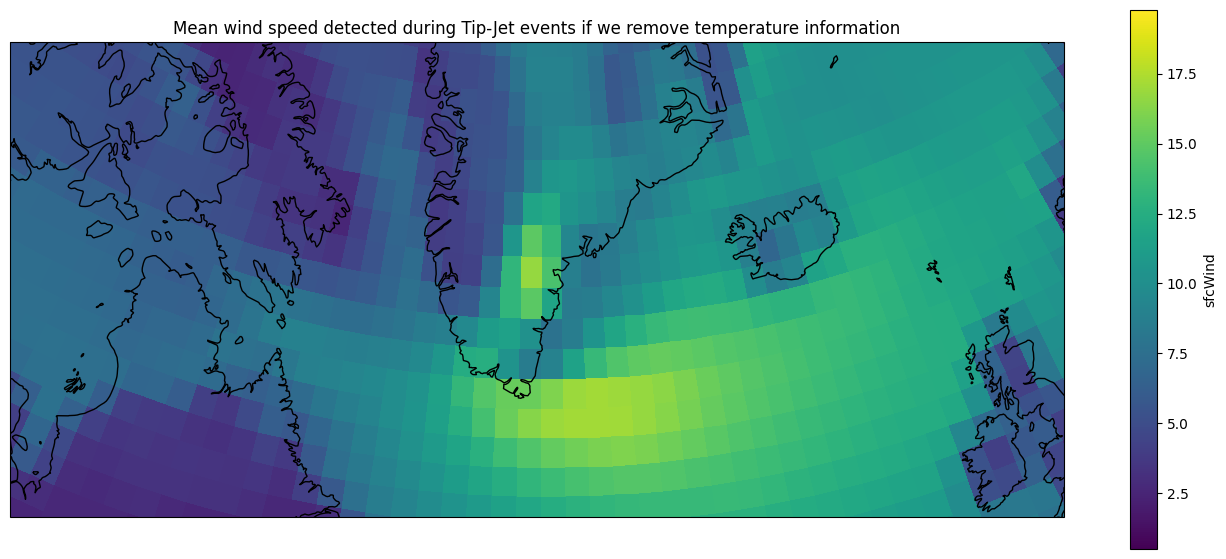

In [47]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ3.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed detected during Tip-Jet events if we remove temperature information")

The difference is really small. Taking into account the temperature slightly increase wind speed on Cape Farewell but it also slightly decrease the wind speed on the east. It is hard to say which one is better.

Text(0.5, 1.0, 'Mean wind speed difference detected during Tip-Jet if we use all features VS if we remove temperature')

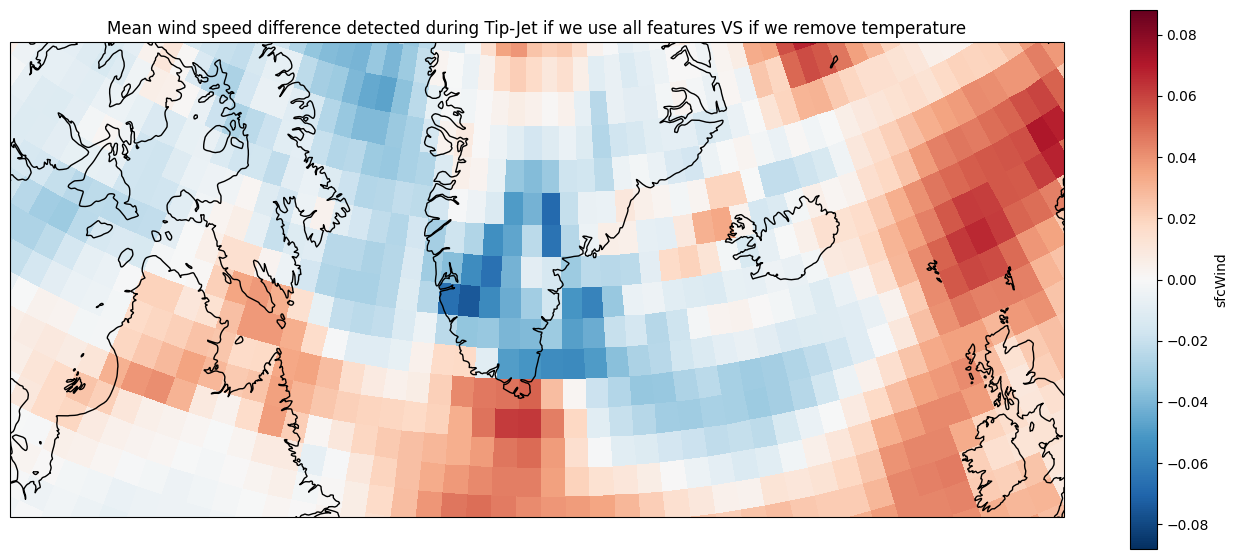

In [48]:
diff_ds_windmag_compositeTJ = ds_windmag_compositeTJ - ds_windmag_compositeTJ3

plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
diff_ds_windmag_compositeTJ.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed difference detected during Tip-Jet if we use all features VS if we remove temperature")

## We will now try to see the results taking into account only the wind

In [49]:
N4, M4 = len(wind_area_u.time.values), 1
X4 = np.zeros((N4, M4))

X4[:, 0] = u_at_max

scaler4 = StandardScaler()
X4 = scaler4.fit_transform(X4)

In [50]:
pca4 = PCA(n_components=1)
pca4.fit(X4)

Xpca4 = pca4.transform(X4)

In [51]:
comp4 = 0

eof4 =  Xpca4[:, comp4]

In [53]:
print(np.percentile(eof4, 95))

events4 = consecutiveGroupes(np.where(eof4>np.percentile(eof4, 95))[0])
len(events4)

1.7246210692024215


840

In [54]:
len(events4)/(2015-1950), 586/(2002-1957)

(12.923076923076923, 13.022222222222222)

In [55]:
ds_windmag_compositeTJ4 = ds_windmag.isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size)).isel(time=np.where(eof4>np.percentile(eof4, 95))[0]).mean('time')

As we can see from the plot bellow, it doesn't correspond to a tip-jet. We don't have on the map an intense azonal wind starting from the Cape Farewell to the east.

Text(0.5, 1.0, 'Mean wind speed detected during Tip-Jet events if we only loof at wind data')

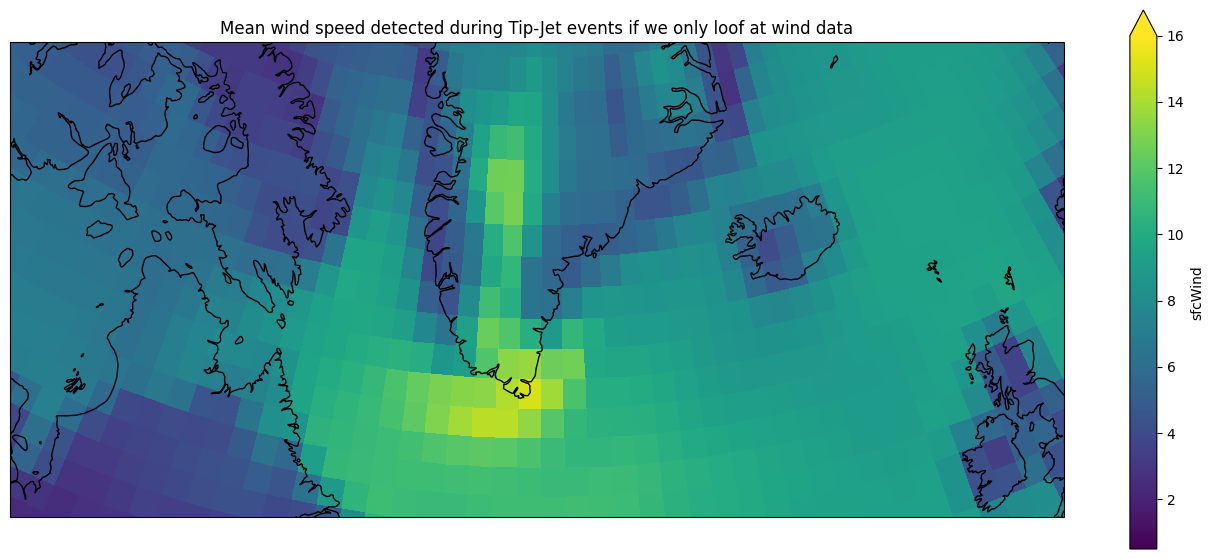

In [58]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ4.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=16)
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed detected during Tip-Jet events if we only loof at wind data")

# Let's now see what happen if we remove two gradient pressure data (we will keep OB)

In [60]:
N5, M5 = len(wind_area_u.time.values), 3
X5 = np.zeros((N5, M5))

X5[:, 0] = u_at_max
X5[:, 1] = t_at_max
X5[:, 2] = grad_b

scaler5 = StandardScaler()
X5 = scaler5.fit_transform(X5)

In [61]:
pca5 = PCA(n_components=1)
pca5.fit(X5)

Xpca5 = pca5.transform(X5)

In [62]:
comp5 = 0

eof5 =  Xpca5[:, comp5]

In [65]:
print(np.percentile(eof5, 95))

events5 = consecutiveGroupes(np.where(eof5>np.percentile(eof5, 95))[0])
len(events5)

2.158279006838559


785

In [66]:
len(events5)/(2015-1950), 586/(2002-1957)

(12.076923076923077, 13.022222222222222)

In [67]:
ds_windmag_compositeTJ5 = ds_windmag.isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size)).isel(time=np.where(eof5>np.percentile(eof5, 95))[0]).mean('time')

Text(0.5, 1.0, 'Mean wind speed detected during Tip-Jet events if we remove two gradient pressure data')

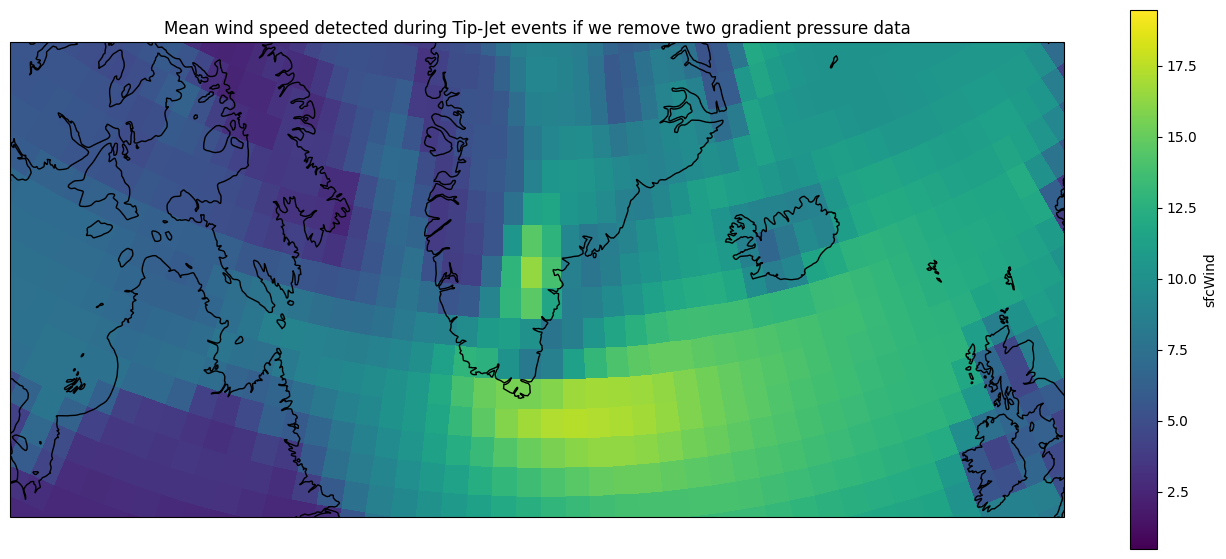

In [69]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
ds_windmag_compositeTJ5.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed detected during Tip-Jet events if we remove two gradient pressure data")

In [71]:
diff_ds_windmag_compositeTJ2 = ds_windmag_compositeTJ - ds_windmag_compositeTJ5

The difference of Tip-Jet detection while keeping all gradient pressure data versus keeping only one gradient pressure is very small. It is hard to say which one is better. Since the paper recommand to use the three gradient pressures, we will use it anyway.

Text(0.5, 1.0, 'Mean wind speed difference detected during Tip-Jet if we use all gradient pressures VS if we keep only one gradient pressure')

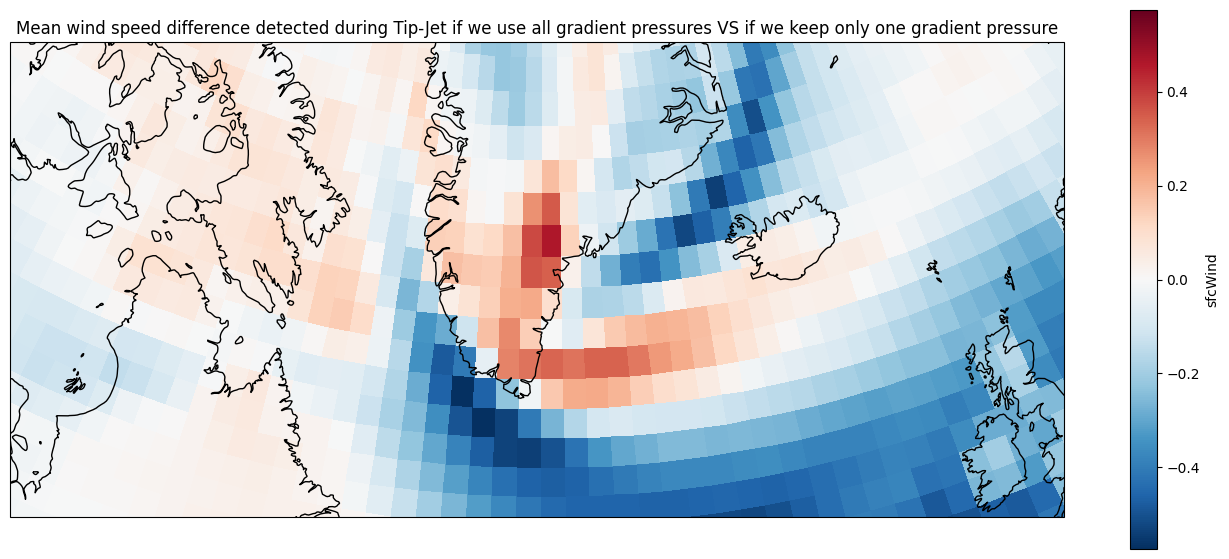

In [73]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
diff_ds_windmag_compositeTJ2.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
ax.set_title("Mean wind speed difference detected during Tip-Jet if we use all gradient pressures VS if we keep only one gradient pressure")